In [7]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
import torch.nn.functional as F
import arff2pandas as a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
"""데이터 불러오기"""
with open('ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

with open('ECG5000_TEST.arff') as f:
  test = a2p.load(f)

5000개의 샘플, 각 변수는 한 명의 심장 박동수를 기록한 것

In [27]:
## 데이터 수 증가를 위해 합치기
df = train.append(test)
df = df.sample(frac=1.0) # 복원 추출
df.shape

(5000, 141)

In [29]:
## 데이터 클래스 정의
    # 심작박동에 대한 정의 5가지
    # 5000개의 행은 단일 심작박동 기록을 나타낸다.
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

In [30]:
## 마지막 열의 이름 변경
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

### EDA

In [31]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


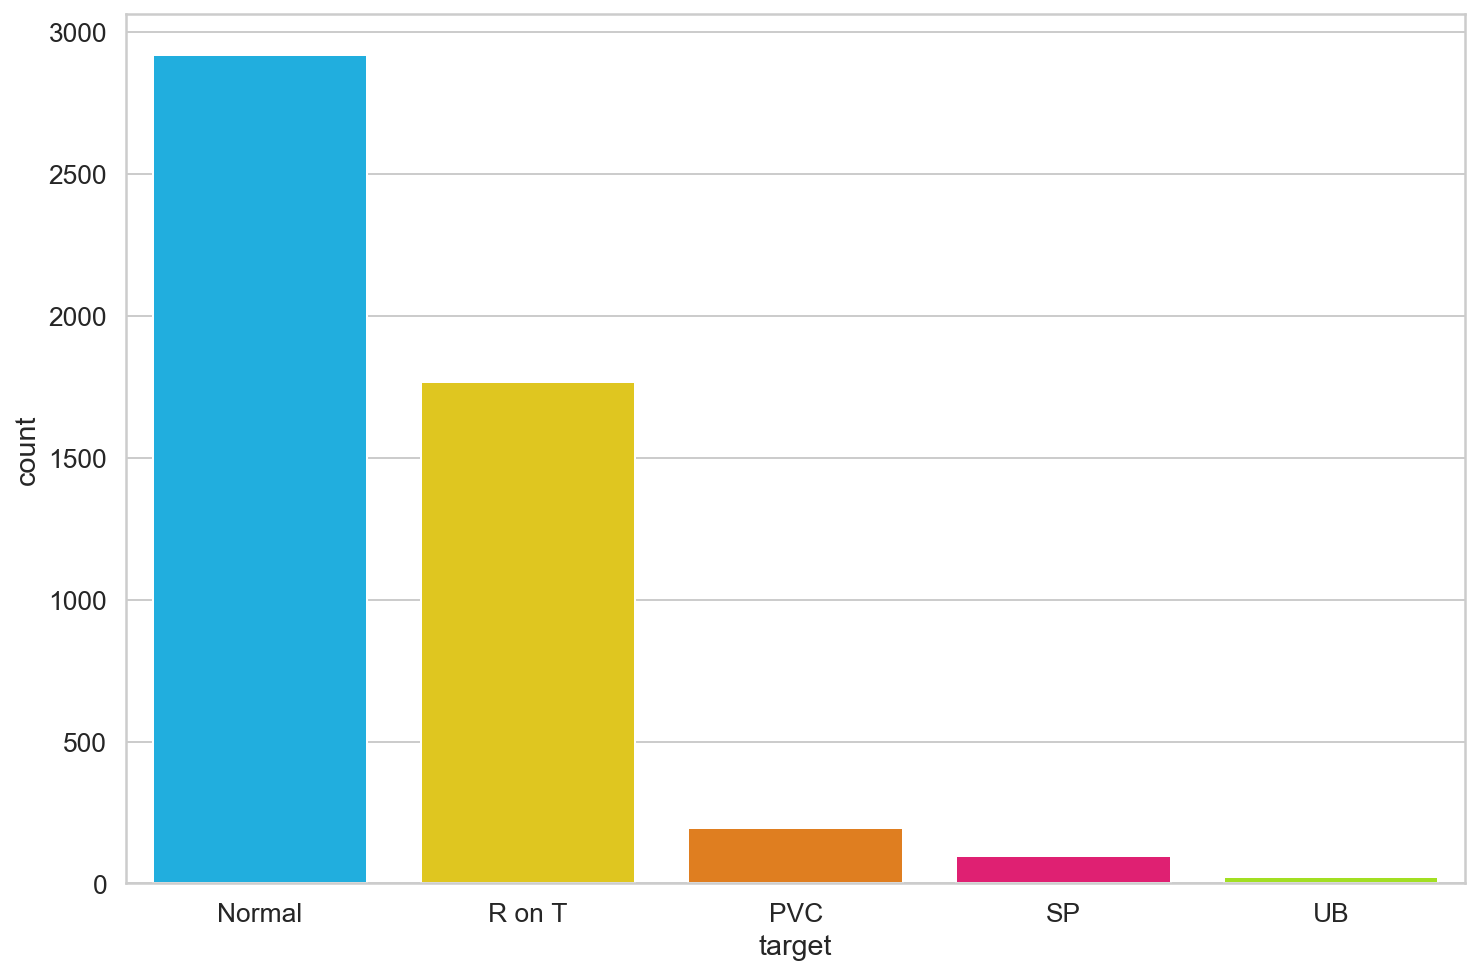

In [32]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

In [34]:
# 각 클래스의 평균 패턴 확인
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
    )
    ax.set_title(class_name)

Normal 클래스는 다른 target값과 다른 패턴을 가지고 있다.

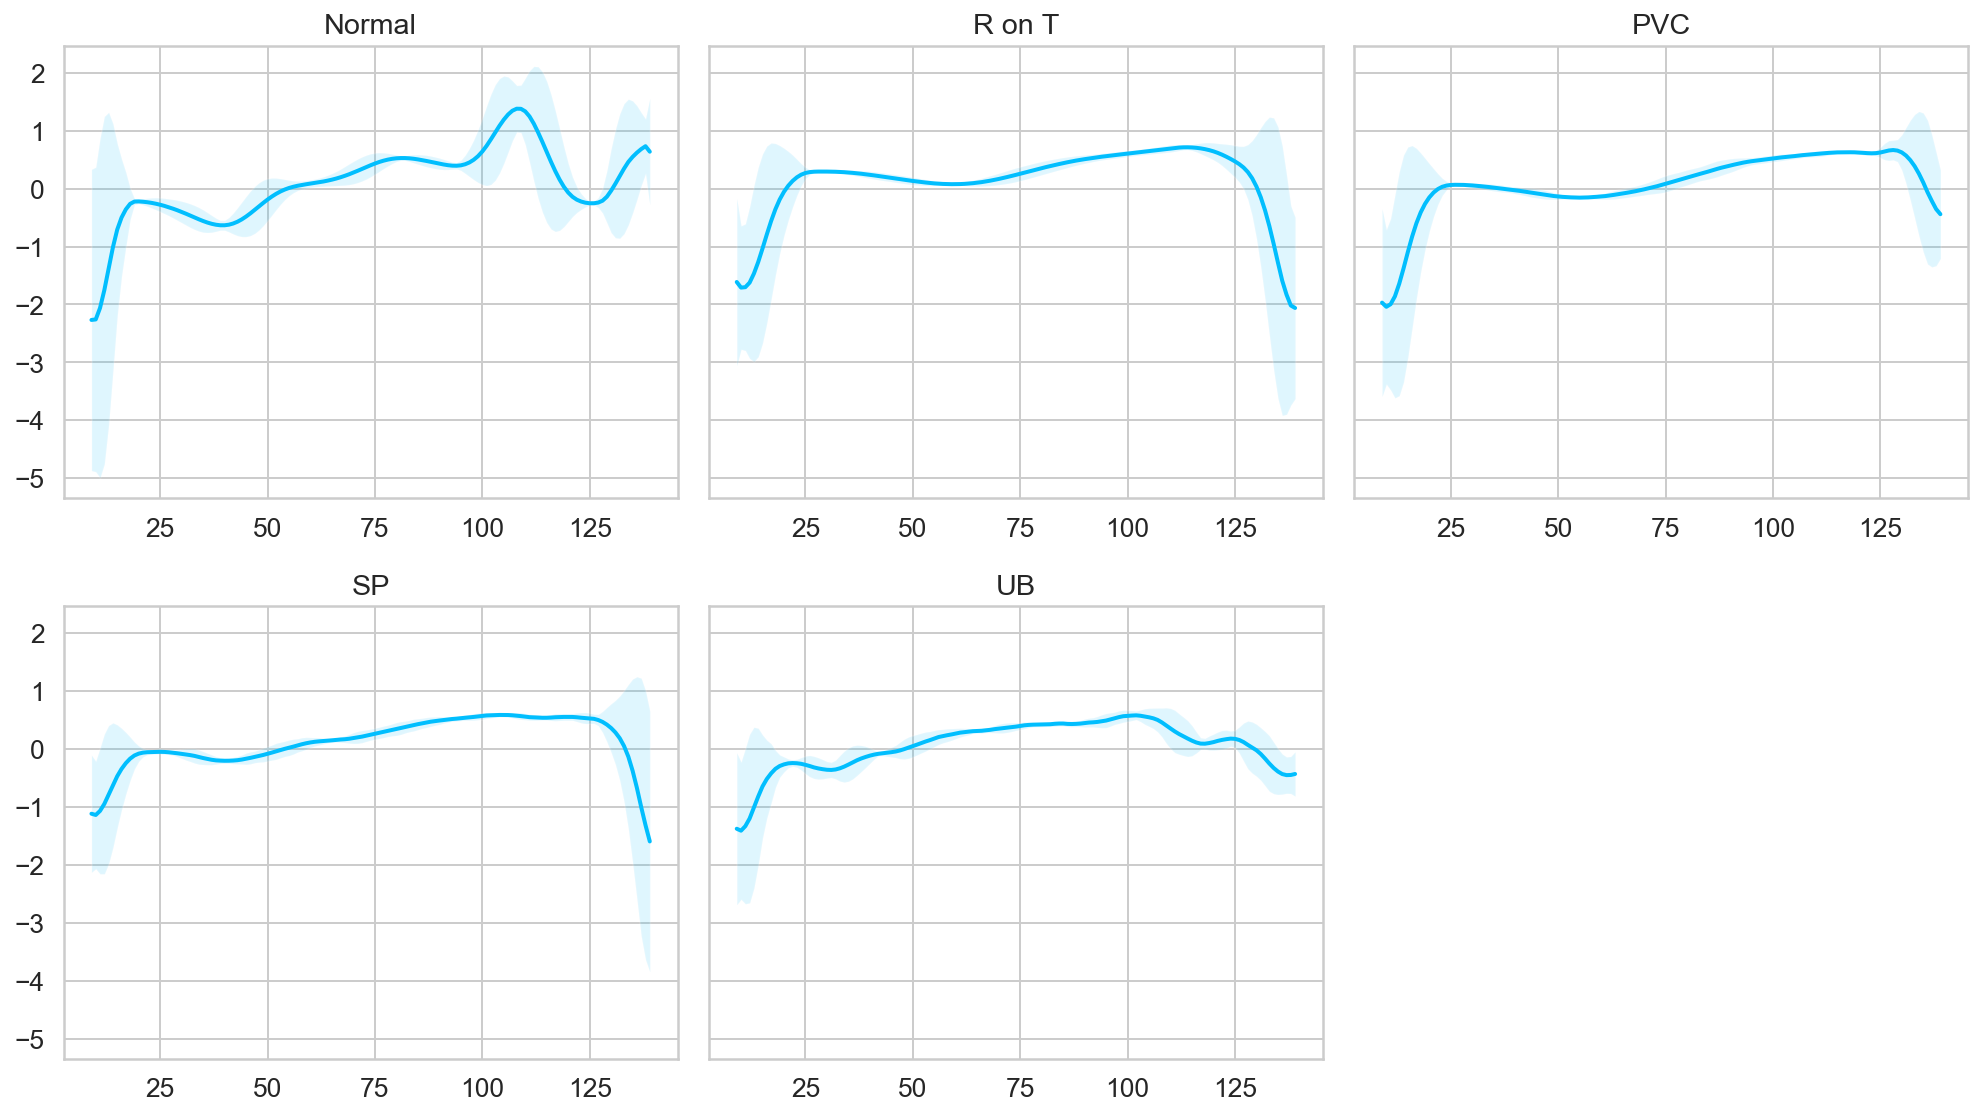

In [35]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

### 모델 정의
- Normal 클래스의 심장 박동을 모델의 훈련 데이터로 사용하고, reconstruction loss를 기록

In [37]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
print('정상 target 데이터 :', normal_df.shape)

anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
print('이상 target 데이터 :', anomaly_df.shape)

정상 target 데이터 : (2919, 140)
이상 target 데이터 : (2081, 140)


In [38]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [45]:
## 텐서로 변환
    # [length, n_features]
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist() # 한 관측치의 모든 변수가 시퀀스가 됨
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [46]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [47]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [48]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [49]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [59]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

### 모델 학습

In [60]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            
            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [61]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=150
)

Epoch 1: train loss 68.64720514521201 val loss 56.904511760933
Epoch 2: train loss 54.205430000455856 val loss 52.074796657106575
Epoch 3: train loss 52.85465569440418 val loss 52.680544374745864
Epoch 4: train loss 53.51705880493755 val loss 52.947092036745246
Epoch 5: train loss 45.816964904034826 val loss 39.42845420381722
Epoch 6: train loss 37.50790875422191 val loss 33.95320430469187
Epoch 7: train loss 35.73665474365431 val loss 32.973478772941306
Epoch 8: train loss 35.062825920984466 val loss 32.549269969145996
Epoch 9: train loss 32.884182022445295 val loss 30.33191870341122
Epoch 10: train loss 29.16999234080747 val loss 29.561954439703516
Epoch 11: train loss 27.096496710417878 val loss 31.112000260336814
Epoch 12: train loss 25.441071211643056 val loss 30.713253639663854
Epoch 13: train loss 24.581747382170537 val loss 26.28807281064499
Epoch 14: train loss 23.1314764503316 val loss 22.55998805765406
Epoch 15: train loss 22.42618721774008 val loss 20.811479548952278
Epoch 

KeyboardInterrupt: 

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [ ]:
MODEL_PATH = 'LSTM_AE_parameter.pth'

torch.save(model, MODEL_PATH)

In [67]:
train_dataset[0].shape

torch.Size([140, 1])

In [69]:
for seq_true in train_dataset:
    seq_true = seq_true.to(device)
    break

In [71]:
train_df

att1      att2      att3      att4      att5      att6      att7  \
2608 -0.919318 -3.014940 -3.384893 -3.981646 -3.828617 -3.234646 -1.804082   
2075 -0.926007 -2.262675 -2.529812 -3.215854 -3.523628 -3.180778 -2.118943   
1742 -1.127530 -2.892678 -4.039125 -4.997514 -4.388872 -2.979173 -1.857898   
150   1.005342  0.754930 -1.212065 -2.788717 -3.712512 -4.549913 -3.850799   
1330 -0.158517 -1.921215 -3.664709 -4.465341 -3.982826 -2.773979 -1.812134   
...        ...       ...       ...       ...       ...       ...       ...   
2110  0.690359 -1.467353 -3.199391 -4.139882 -3.919458 -3.257177 -2.212842   
56   -0.415819 -2.669981 -3.918828 -4.285928 -4.173037 -3.586434 -2.478273   
892  -1.134110 -3.059297 -3.866269 -4.304981 -4.065429 -3.514084 -2.591911   
2366 -0.023095 -2.611266 -4.018630 -4.294045 -3.926619 -3.242963 -2.121322   
84   -1.542954 -2.825838 -3.539836 -4.424830 -4.632484 -3.860005 -2.301716   

          att8      att9     att10  ...    att131    att132    att133  \
2608 -1.140253 -0.655269  0.352905  ...  1.403169  1.211733  1.471334   
2075 -0.922453 -0.499912 -0.213151  ...  0.355101  0.053107 -0.464577   
1742 -1.661818 -0.880471 -0.187055  ...  1.009903  1.913275  1.925496   
150  -2.322095 -1.646850 -1.357239  ... -0.940618 -0.136767  0.269292   
1330 -1.690512 -1.092731 -0.281107  ...  1.191885  0.997710  0.857177   
...        ...       ...       ...  ...       ...       ...       ...   
2110 -1.647828 -1.549699 -0.854778  ...  0.647149  0.828539  0.632007   
56   -1.607117 -1.203307 -0.619225  ...  1.013486  1.186335  1.486340   
892  -1.595504 -1.336082 -1.125177  ...  1.628770  1.519559  1.490954   
2366 -1.506411 -1.189799 -0.489618  ...  1.010186  1.051499  1.413350   
84   -1.350052 -0.535208  0.395753  ...  0.710485  1.332507  1.291515   

        att134    att135    att136    att137    att138    att139    att140  
2608  1.036322  0.224713 -0.791020 -0.645683 -0.361866 -0.113474 -1.988195  
2075 -1.193877 -1.775372 -2.310713 -2.060028 -1.767327 -2.258348 -3.835663  
1742  2.236572  2.564307  1.803879  0.281025 -0.902882 -0.750354 -1.008387  
150   0.235111  0.581392  0.245466  0.296737 -0.834586 -0.924241 -0.625913  
1330  1.085414  1.075929  0.989721  1.051740  1.386680  2.041922  1.056013  
...        ...       ...       ...       ...       ...       ...       ...  
2110  0.941910  1.202857  1.200362  1.405531  1.665317  2.379915  1.092986  
56    1.665004  1.433940  0.850226  0.403449  0.602889  1.137776 -0.144081  
892   1.239195  0.671416 -0.104259 -0.404891 -0.258704  0.117062 -1.139245  
2366  1.495256  1.300596  0.940931  1.217202  1.649980  0.919810 -1.965695  
84    1.851066  2.070146  1.292510 -0.025679 -0.903875 -1.126167 -2.544891  

[2481 rows x 140 columns]

In [70]:
seq_true.shape

torch.Size([140, 1])

In [ ]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [ ]:
sequences = df.astype(np.float32).to_numpy().tolist()

In [72]:
train_df.astype(np.float32).to_numpy().tolist()

[[-0.919318437576294,
  -3.014940023422241,
  -3.384892702102661,
  -3.9816460609436035,
  -3.8286168575286865,
  -3.2346456050872803,
  -1.8040815591812134,
  -1.1402528285980225,
  -0.6552692651748657,
  0.3529048264026642,
  0.5624149441719055,
  0.5567113161087036,
  0.7752444744110107,
  0.5462616086006165,
  0.24742165207862854,
  0.4204827547073364,
  0.6935843825340271,
  0.8205724358558655,
  0.7638716101646423,
  0.7181681990623474,
  0.7211477756500244,
  0.4993496835231781,
  0.3127167224884033,
  -0.046555183827877045,
  -0.39656713604927063,
  -0.7425832152366638,
  -0.4830397069454193,
  -0.11567804217338562,
  -0.4389845132827759,
  -0.3545156717300415,
  -0.10054917633533478,
  -0.4430428147315979,
  -0.38533926010131836,
  -0.061421193182468414,
  0.08916859328746796,
  0.2722012996673584,
  0.010468336753547192,
  -0.19890645146369934,
  -0.15162229537963867,
  -0.24893085658550262,
  -0.6624932289123535,
  -0.8932126760482788,
  -0.7553997039794922,
  -0.30610120296